<a href="https://colab.research.google.com/github/emjames/neural-networks/blob/master/regression/Regression_Fuel_Efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression: Predict fuel efficiency
This notebook roughly follows [this TensorFlow tutorial](https://www.tensorflow.org/tutorials/keras/basic_regression)

The objective of *regression* is to predict the output of a continuous value, like a price or a probability. Whereas in *classification*, we have a list of classes and we have to select one of them.


## Model

Predict the fuel efficiency of late-1970s and early 1980s automobiles. We'll provide the model with a description of many automobiles from that time period. This description include attributes like: culinders, displacement, horsepower, and weight.


This notebooks uses the tf.keras API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [0]:
# Use seaborn for pairplot
!pip install -q seaborn

In [0]:
# from __future__ inport absolute_import, division, print_function # we're in 3.6, we don't need this
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!python --version
print(tf.__version__)

Python 3.6.7
1.13.1


# Data

This notebook uses the [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset.  

Attribute Information:

1. mpg: continuous 
2. cylinders: multi-valued discrete 
3. displacement: continuous 
4. horsepower: continuous 
5. weight: continuous 
6. acceleration: continuous 
7. model year: multi-valued discrete 
8. origin: multi-valued discrete
9. ~~car name: string (unique for each instance)~~

## Get the data

In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

## Explore

In [5]:
column_names  = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                 'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path,
                      names=column_names,
                      na_values="?",
                      comment='\t',
                      sep=" ",
                      skipinitialspace=True)
print(dataset.shape)
dataset.tail()

(398, 8)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the data
Remove unknow values. To keep this tutorial simple we will drop those rows.

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
# drop na
dataset = dataset.dropna()

The "Origin" column is really categorical, not numeric. So convert that to a one-hot:

In [8]:
# unique values
dataset['Origin'].unique()

array([1, 3, 2])

In [9]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## Split the data into train and test
Now split the dataset into a training set and a test set.  
The test set is used in the final evaluation of our model.

In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Inspect the data

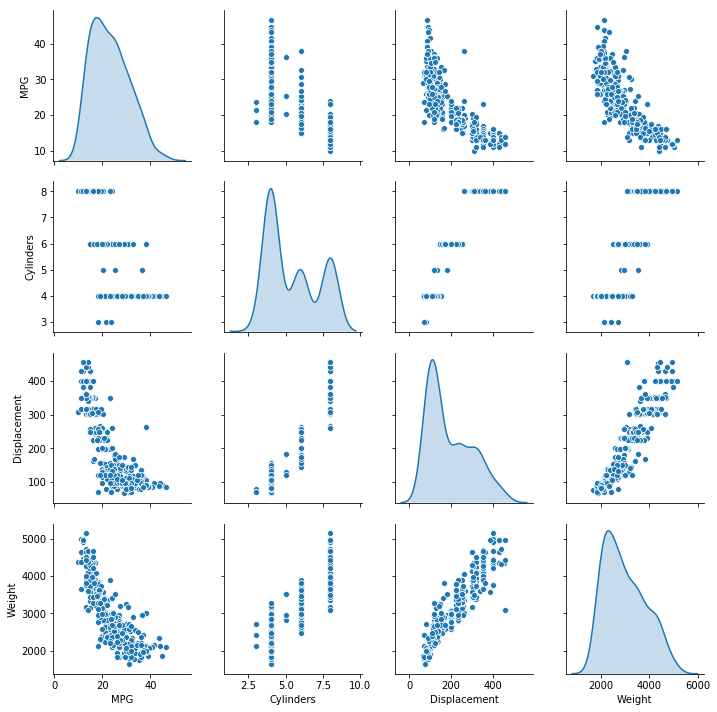

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


### Overall statistics

In [12]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## Split features from labels
Separate the target value, or "label", from the fatures. This label is the value that you will train the model to predict.

In [0]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

## Normalize the data
Look again at the `train_stats` block above and ntoe how different the range of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

**Note:** Althought  we intentionally generrate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [18]:
normed_train_data.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,0.774676,-0.465148,-0.495225
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,0.774676,-0.465148,-0.495225
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-1.286751,-0.465148,2.012852
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-1.286751,-0.465148,2.012852
182,-0.869348,-0.846517,-0.495310,-0.623596,-0.021237,0.027726,-1.286751,2.143005,-0.495225


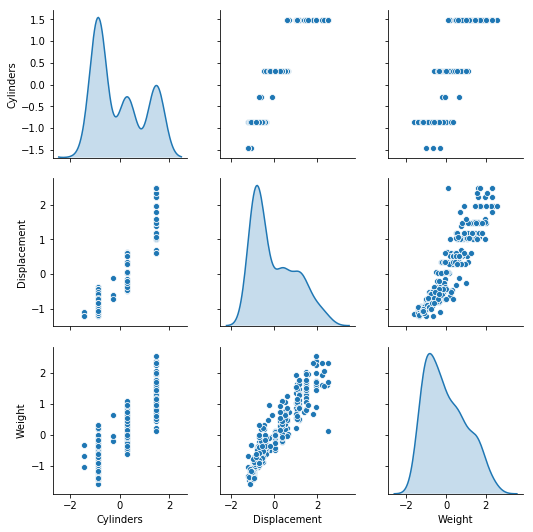

In [17]:
sns.pairplot(normed_train_data[["Cylinders", "Displacement", "Weight"]], diag_kind="kde")
